# Projekt WDSNIUM: Autoenkoder do kolorowania obrazów czarno-białych
## Autorzy: Iga Pietrusiewicz, Szymon Baliński

### Opis dataset'u
Zbiór danych "LHQ 1024", dostępny na Kaggle, składa się z 90,000 wysokiej rozdzielczości obrazów krajobrazów naturalnych, pozyskanych z Unsplash i Flickr. Obrazy zostały przetworzone przy użyciu Mask R-CNN i Inception V3, co zapewnia ich wysoką jakość i adekwatność do zastosowań w sztucznej inteligencji. Jest to wartościowy zbiór danych dla zastosowań wizualnych, oferujący szeroki zakres scen krajobrazowych.


![Przegląd dataset'u](figures/dataset.png)
https://www.kaggle.com/datasets/dimensi0n/lhq-1024/data

Ze zbioru danych zostały wyciągnięte pierwsze 8000 obrazów, które następnie zostały przekonwertowane na skalę szarości.

In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [13]:
SIZE = 160
color_images_path = './data5/color'
gray_images_path = './data5/gray'

In [14]:
color_images = []
gray_images = []

zip_images = list(zip(os.listdir(color_images_path), os.listdir(gray_images_path)))
for (color_file, gray_file) in tqdm(zip_images):
    # Handle color files
    color_img = cv2.imread(os.path.join(color_images_path, color_file), 1)
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
    color_img = cv2.resize(color_img, (SIZE, SIZE))
    color_img = color_img.astype('float32') / 255.0
    color_images.append(img_to_array(color_img))

    # Handle gray files
    gray_img = cv2.imread(os.path.join(gray_images_path, gray_file), 1)
    gray_img = cv2.resize(gray_img, (SIZE, SIZE))
    gray_img = gray_img.astype('float32') / 255.0
    gray_images.append(img_to_array(gray_img))

number_of_images = len(color_images)

100%|██████████| 8000/8000 [03:59<00:00, 33.41it/s]


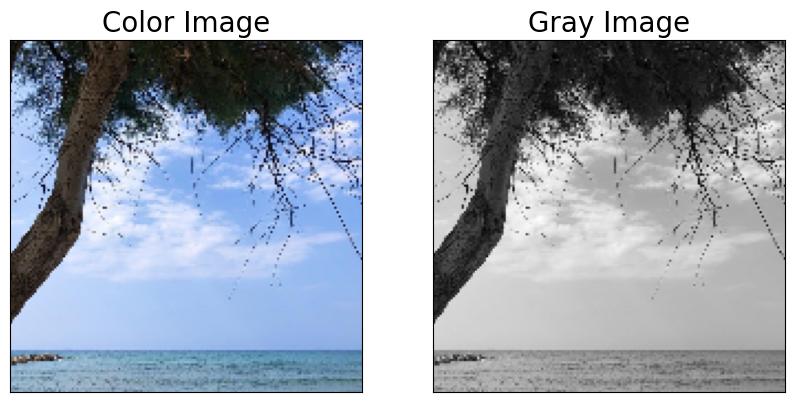

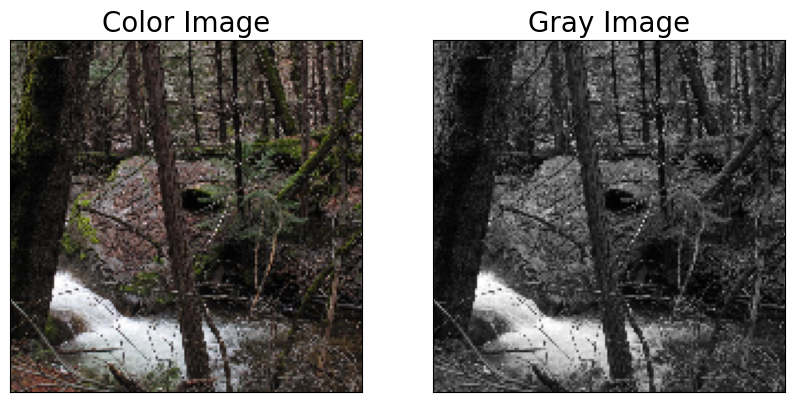

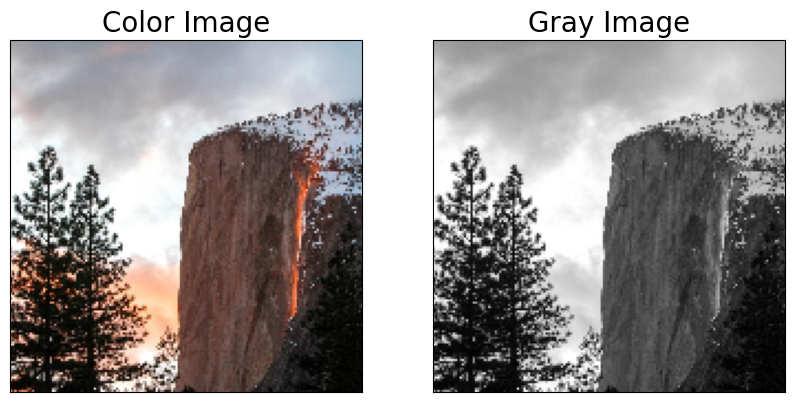

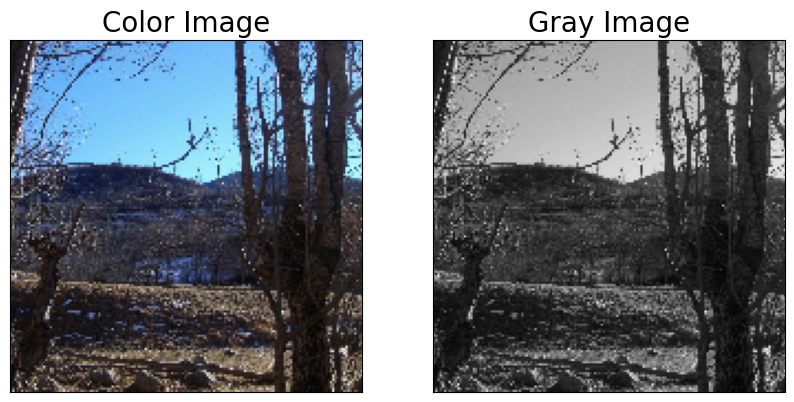

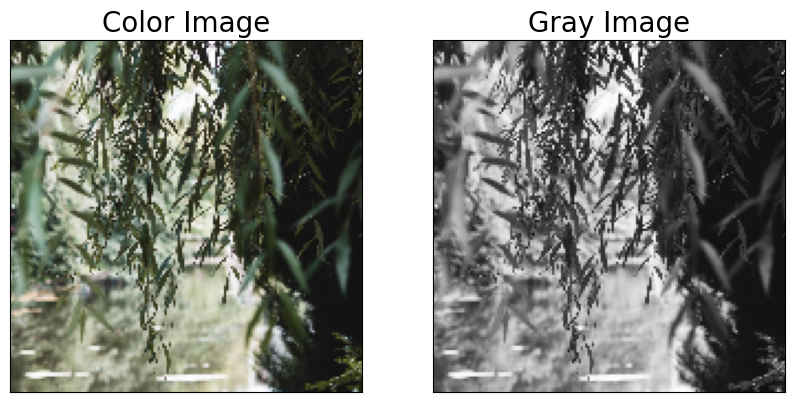

In [15]:
def plot_images(images, labels):
    plt.figure(figsize=(5*len(images), 5*len(images)))

    for i, (image, label) in enumerate(zip(images, labels)):
        ax = plt.subplot(1, len(images), i+1)
        ax.set_facecolor('white')
        plt.title(label, color='black', fontsize=20)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

    plt.show()

# Display 5 random images
for i in range(5):
    image_id = random.randint(0, number_of_images)
    plot_images([color_images[image_id], gray_images[image_id]], ['Color Image', 'Gray Image'])

In [16]:
# Split data
train_gray_image = gray_images[:int(0.8 * number_of_images)]
train_color_image = color_images[:int(0.8 * number_of_images)]

test_gray_image = gray_images[int(0.8 * number_of_images):]
test_color_image = color_images[int(0.8 * number_of_images):]

# Reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)
print('Train gray image shape:',train_g.shape)

test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)
print('Test gray image shape',test_gray_image.shape)

Train color image shape: (6400, 160, 160, 3)
Train gray image shape: (6400, 160, 160, 3)
Test color image shape (1600, 160, 160, 3)
Test gray image shape (1600, 160, 160, 3)


In [17]:
# Defining model
def model():
    inputs = keras.layers.Input(shape=[160, 160, 3])

    # Downsampling
    d1 = keras.layers.Conv2D(128, (3, 3), padding='same', strides=2)(inputs)
    d1 = keras.layers.LeakyReLU()(d1)

    d2 = keras.layers.Conv2D(128, (3, 3), padding='same', strides=2)(d1)
    d2 = keras.layers.LeakyReLU()(d2)

    d3 = keras.layers.Conv2D(256, (3, 3), padding='same', strides=2)(d2)
    d3 = keras.layers.BatchNormalization()(d3)
    d3 = keras.layers.LeakyReLU()(d3)

    d4 = keras.layers.Conv2D(512, (3, 3), padding='same', strides=2)(d3)
    d4 = keras.layers.BatchNormalization()(d4)
    d4 = keras.layers.LeakyReLU()(d4)

    d5 = keras.layers.Conv2D(512, (3, 3), padding='same', strides=2)(d4)
    d5 = keras.layers.BatchNormalization()(d5)
    d5 = keras.layers.LeakyReLU()(d5)

    # Upsampling
    u1 = keras.layers.Conv2DTranspose(512, (3, 3), padding='same', strides=2)(d5)
    u1 = keras.layers.LeakyReLU()(u1)
    u1 = keras.layers.concatenate([u1, d4])

    u2 = keras.layers.Conv2DTranspose(256, (3, 3), padding='same', strides=2)(u1)
    u2 = keras.layers.LeakyReLU()(u2)
    u2 = keras.layers.concatenate([u2, d3])

    u3 = keras.layers.Conv2DTranspose(128, (3, 3), padding='same', strides=2)(u2)
    u3 = keras.layers.LeakyReLU()(u3)
    u3 = keras.layers.concatenate([u3, d2])

    u4 = keras.layers.Conv2DTranspose(128, (3, 3), padding='same', strides=2)(u3)
    u4 = keras.layers.LeakyReLU()(u4)
    u4 = keras.layers.concatenate([u4, d1])

    u5 = keras.layers.Conv2DTranspose(3, (3, 3), padding='same', strides=2)(u4)
    u5 = keras.layers.LeakyReLU()(u5)
    u5 = keras.layers.concatenate([u5, inputs])

    output = keras.layers.Conv2D(3, (2, 2), strides=1, padding='same')(u5)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [18]:
# Creating model
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 80, 80, 128)          3584      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)  (None, 80, 80, 128)          0         ['conv2d_10[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)          (None, 40, 40, 128)          147584    ['leaky_re_lu_14[0][0]']      
                                                                                              

In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_absolute_error',
              metrics = ['acc']
              )

history = model.fit(train_g, train_c, epochs = 40, batch_size = 40,verbose = 1)

Epoch 1/40


160/160 [==============================] - 258s 2s/step - loss: 0.1578 - acc: 0.3797
Epoch 2/40
160/160 [==============================] - 326s 2s/step - loss: 0.0834 - acc: 0.4017
Epoch 3/40
160/160 [==============================] - 244s 2s/step - loss: 0.0688 - acc: 0.4170
Epoch 4/40
160/160 [==============================] - 242s 2s/step - loss: 0.0595 - acc: 0.4294
Epoch 5/40
160/160 [==============================] - 242s 2s/step - loss: 0.0549 - acc: 0.4394
Epoch 6/40
160/160 [==============================] - 340s 2s/step - loss: 0.0521 - acc: 0.4496
Epoch 7/40
160/160 [==============================] - 342s 2s/step - loss: 0.0510 - acc: 0.4498
Epoch 8/40
160/160 [==============================] - 232s 1s/step - loss: 0.0500 - acc: 0.4537
Epoch 9/40
160/160 [==============================] - 221s 1s/step - loss: 0.0488 - acc: 0.4604
Epoch 10/40
160/160 [==============================] - 200s 1s/step - loss: 0.0487 - acc: 0.4619
Epoch 11/40
160/160 [================

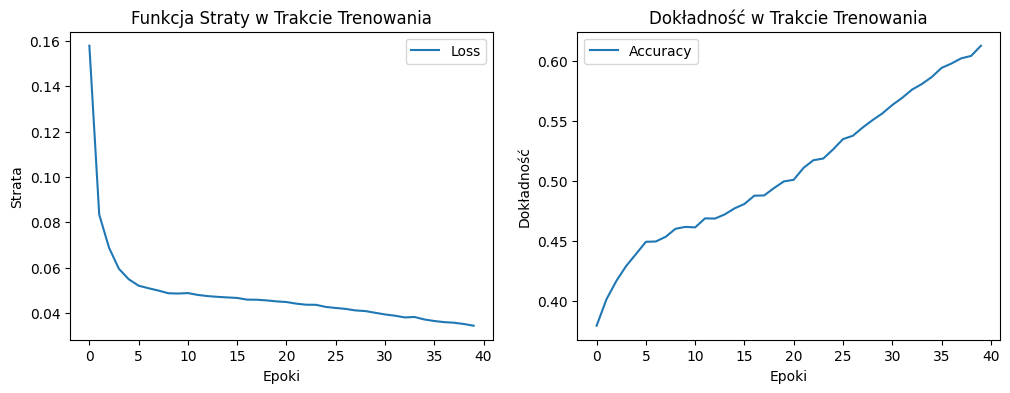

In [20]:
# Wykres dla funkcji straty
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Funkcja Straty w Trakcie Trenowania')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

# Wykres dla dokładności
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Accuracy')
plt.title('Dokładność w Trakcie Trenowania')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

plt.show()

In [21]:
model.evaluate(test_gray_image,test_color_image)

50/50 [==============================] - 15s 265ms/step - loss: 0.0516 - acc: 0.4997


[0.05160532146692276, 0.4996596574783325]

1/1 [==============================] - 0s 38ms/step


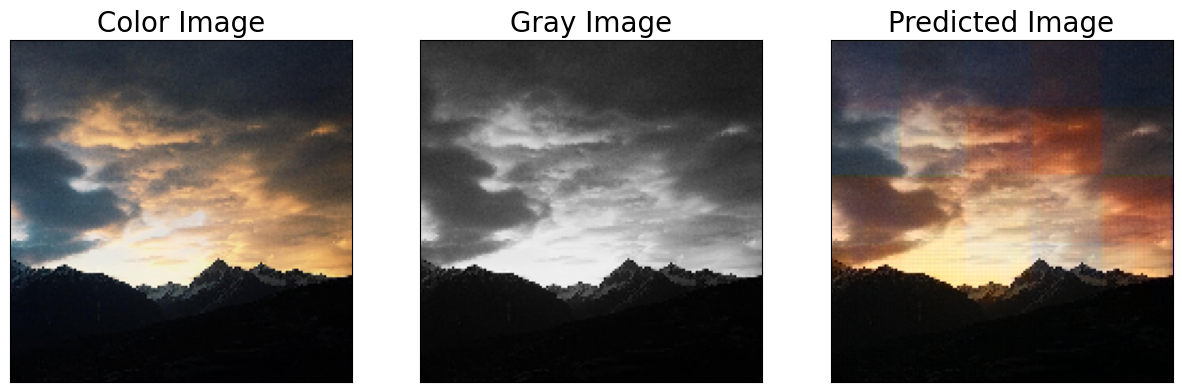

1/1 [==============================] - 0s 34ms/step


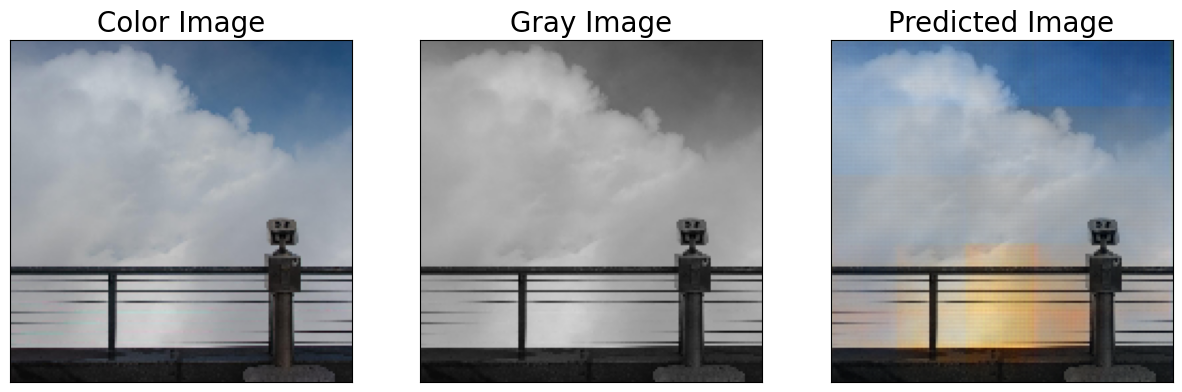

1/1 [==============================] - 0s 37ms/step


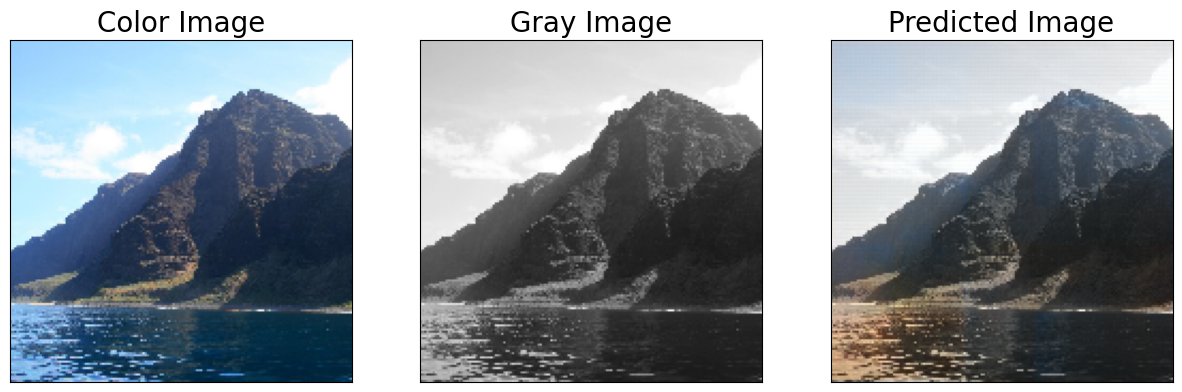

1/1 [==============================] - 0s 35ms/step


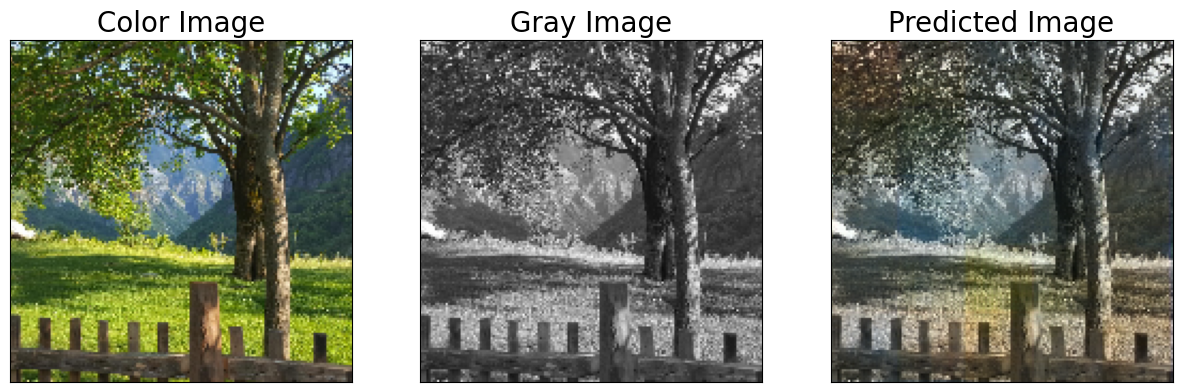

1/1 [==============================] - 0s 34ms/step


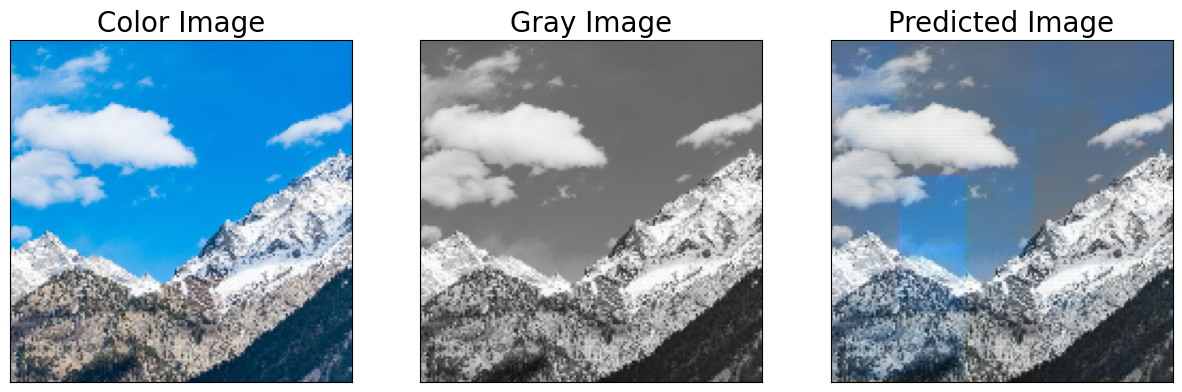

In [35]:
for i in range(5):
    random_id = random.randint(0, int(0.2 * number_of_images))
    predicted = np.clip(model.predict(test_gray_image[random_id].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)

    plot_images([test_color_image[random_id], test_gray_image[random_id], predicted], ['Color Image', 'Gray Image', 'Predicted Image'])

In [36]:
model.save('model.h5')

C:\Users\Szymon\.conda\envs\AIjupyter310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 36ms/step


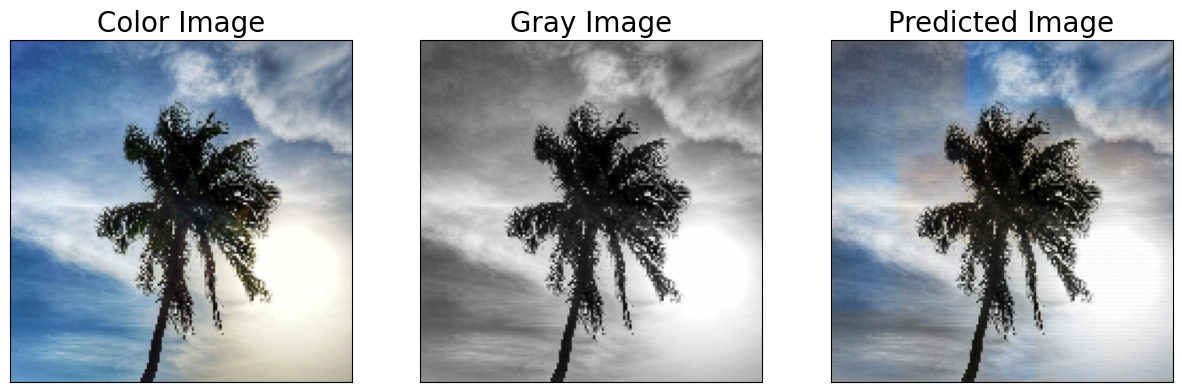

1/1 [==============================] - 0s 37ms/step


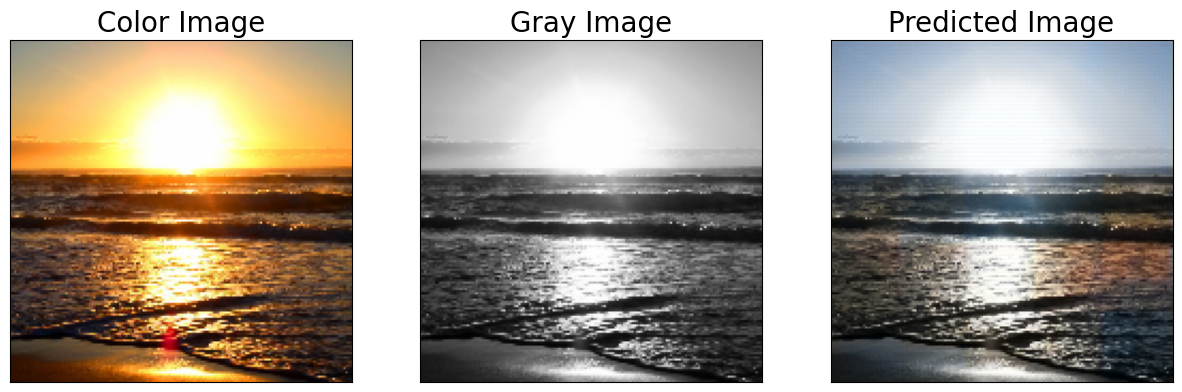

1/1 [==============================] - 0s 37ms/step


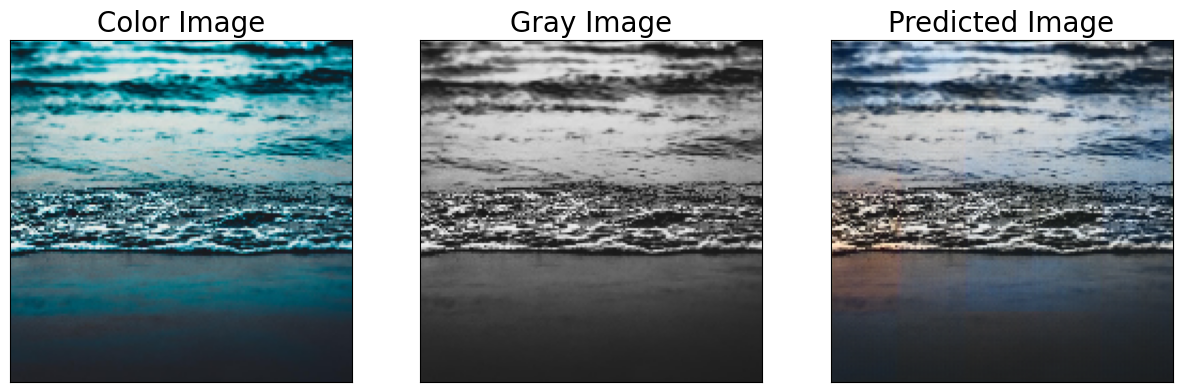

1/1 [==============================] - 0s 40ms/step


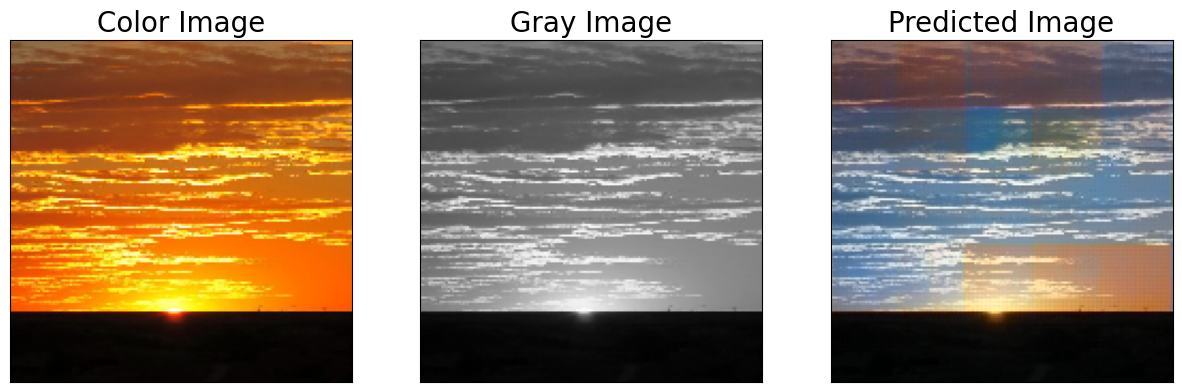

1/1 [==============================] - 0s 36ms/step


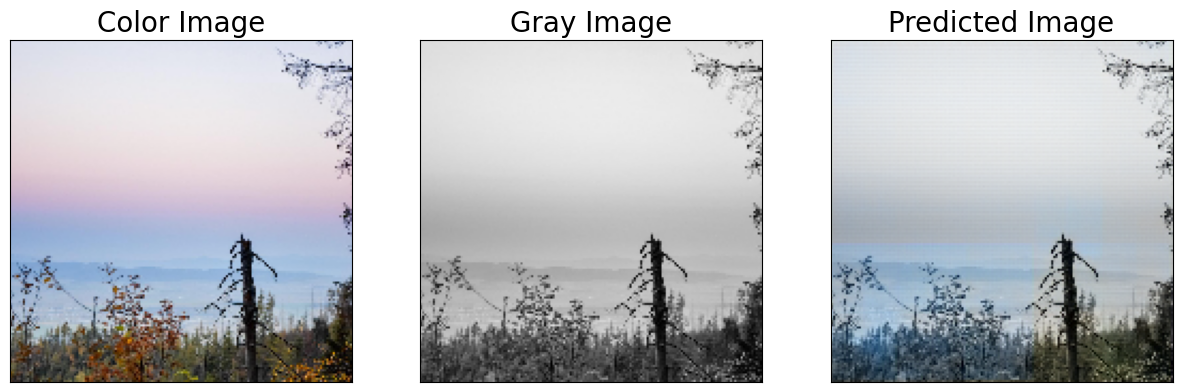

In [39]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model.h5')

for i in range(5):
    random_id = random.randint(0, int(0.2 * number_of_images))
    predicted = np.clip(model.predict(test_gray_image[random_id].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)

    plot_images([test_color_image[random_id], test_gray_image[random_id], predicted], ['Color Image', 'Gray Image', 'Predicted Image'])